# Multi-fidelity Gaussian process regression (MFGPR) in F3DASM

## 0. Goal of this notebook
This notebook serves to answer the following questions in order:
1. Which Python packages do I need to import in order to perform MFGPR in F3DASM, and why?
2. How do I define an analytic data source and generate training data for MFGPR?
3. What are the hyperparameters that MFGPR uses and do I define them?
4. How do I train a MFGP regressor and evaluate the subsequent surrogate model at each fidelity?
5. Which error metrics are used to determine the quality of a MFGP surrogate model?

## 1. Package dependencies

We first import the `f3dasm` library, which serves as the framework for doing GPR.

In [1]:
import f3dasm

2023-03-06 16:34:01.138030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:34:01.275683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 16:34:01.275723: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-06 16:34:02.012705: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


The MFGPR pipeline in F3DASM is based on the `pytorch` framework. As such, we need to import these packages:

In [2]:
import torch, gpytorch

Lastly, we need to import the following packages to do the necessary intermediate math and visualization.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 2. Training data

We will look at a 1D regression problem, previously explored by Forrester [REFERENCE].

### 2.1 Analytic data source (Forrester function)
Not only does F3DASM provide its own analytic functions to sample data from, it is also possible to define our own function adapted to the framework. 

In this case, we define the high- and low-fidelity Forrester functions, as used in [REFERENCE].

In [4]:
class Forrester(f3dasm.functions.Function):
    def __init__(self, dimensionality: int = 1, seed: int = None):
        super().__init__(dimensionality, seed)

    def f(self, x):
        return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

class Forrester_lf(f3dasm.functions.Function):
    def __init__(self, dimensionality: int = 1, seed: int = None):
        super().__init__(dimensionality, seed)

    def f(self, x):
        return 0.5 * (6 * x - 2) ** 2 * np.sin(12 * x - 4) + 10 * (x - 0.5) - 5
    
fun_hf = Forrester()
fun_lf = Forrester_lf()

2023-03-06 16:34:05.122703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 16:34:05.123082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-06 16:34:05.123153: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-03-06 16:34:05.123215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-03-06 16:34:05.123276: W tensorflow/compile

Let's plot the functions.

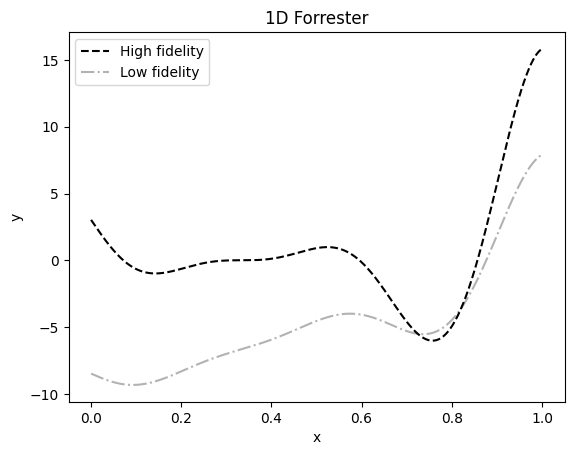

In [5]:
x_plot = np.linspace(0, 1, 500)[:, None] 
y_hf_plot = fun_hf(x_plot)
y_lf_plot = fun_lf(x_plot)

## Initialize plot
f, ax = plt.subplots(1, 1)

## Plot high-fidelity ground truth as black dashed line
ax.plot(x_plot, y_hf_plot, 'k--')

## Plot low-fidelity ground truth as grey dash-dotted line
ax.plot(x_plot, y_lf_plot, 'k-.', alpha=.3)

## Add labels, legend and title
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['High fidelity', 'Low fidelity'])
plt.title('1D ' + fun_hf.get_name())

plt.show()

### 2.2 Formatting the training data

Setting up the data for a multi-fidelity problem is similar to the case of doing [GPR in F3DASM](./f3dasm_sogpr.ipynb), with the exception that this has to be done for every fidelity.

In the scope of reproducing the result from [REFERENCE], we use the same training data.

In [6]:
seed = 123

mf_train_data = []
funs = []

for fid_no in [0, 1]:

    if fid_no == 0:
        fun = fun_lf
    else:
        fun = fun_hf
    funs.append(fun)
    
    parameter_DesignSpace = f3dasm.make_nd_continuous_design(
        bounds=np.tile([0.0, 1.0], (1, 1)),
        dimensionality=1,
    )

    sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace, seed=seed)

    train_data = f3dasm.ExperimentData(design=parameter_DesignSpace)

    if fid_no == 1:
        input_array = np.array([0., 0.4, 0.6, 1.])[:, None]
    else:
        input_array = np.linspace(0, 1, 11)[:, None]

    train_data.add_numpy_arrays(
        input=input_array, 
        output=np.full_like(input_array, np.nan)
        )

    output = fun(train_data) 

    train_x = torch.tensor(train_data.get_input_data().values)
    train_y = torch.tensor(train_data.get_output_data().values.flatten())

    ## Scaling the output based on low fidelity data
    if fid_no == 0:
        scaler = StandardScaler()
        scaler.fit(train_y.numpy()[:, None])
    train_y_scaled = torch.tensor(scaler.transform(train_y.numpy()[:, None]).flatten())

    train_data.add_output(output=train_y_scaled)

    mf_train_data.append(train_data)

In [7]:
mf_train_data[1].get_input_data().values

array([[0. ],
       [0.4],
       [0.6],
       [1. ]])

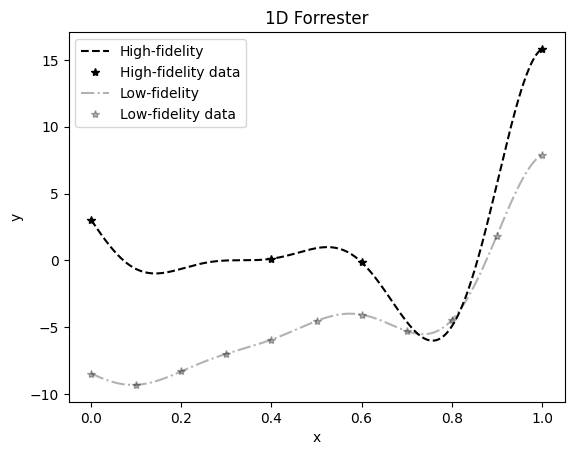

In [8]:
# Initialize plot
f, ax = plt.subplots(1, 1)

## Plot high-fidelity ground truth as black dashed line
ax.plot(x_plot, y_hf_plot, 'k--')

# Plot high-fidelity training data as black stars
ax.plot(mf_train_data[1].get_input_data(), scaler.inverse_transform(mf_train_data[1].get_output_data().values), 'k*')

## Plot low-fidelity ground truth as grey dash-dotted line
ax.plot(x_plot, y_lf_plot, 'k-.', alpha=.3)

# Plot low-fidelity training data as black stars
ax.plot(mf_train_data[0].get_input_data(), scaler.inverse_transform(mf_train_data[0].get_output_data().values), 'k*', alpha=.3)

# Add labels, legend and title
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['High-fidelity', 'High-fidelity data', 'Low-fidelity', 'Low-fidelity data'])
plt.title('1D ' + fun.get_name())

plt.show()

## 3. Define the hyperparameters

The hyperparameters for cokriging with joint model selection (cokgj) are set up in a similar way as the GPR tutorial. For this setup, the only difference is that a list of `gpytorch` covariance and mean modules are required:

In [36]:
mean_module_list = torch.nn.ModuleList([
    gpytorch.means.ZeroMean(),
    gpytorch.means.ZeroMean()
])

covar_module_list = torch.nn.ModuleList([
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()),
])

The other parameters are similar as in the case of GPR:

In [37]:
## Likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

## Likelihood optimizer
opt_algo = torch.optim.Adam
opt_algo_kwargs = dict(lr=0.1)
training_iter = 150

## Noisy data?
noisy_data_bool = True

## Output training info?
verbose_training = True

## 4. Regression and prediction


In order to perform cokgj, the hyperparameters are first gathered in a `Cokgj_Parameters` object.

In [38]:
param = f3dasm.machinelearning.gpr.Cokgj_Parameters(
    kernel=covar_module_list,
    mean=mean_module_list,
    likelihood=likelihood,
    noise_fix=1 - noisy_data_bool,
    opt_algo=opt_algo,
    opt_algo_kwargs=opt_algo_kwargs,
    verbose_training=verbose_training,
    training_iter=training_iter,
    )

Then, we initialize an untrained regressor:

In [39]:
regressor = f3dasm.machinelearning.gpr.Cokgj(
    mf_train_data=mf_train_data,
    parameter=param,
)

Next, let's train the regressor:

In [40]:
surrogate = regressor.train()


Iter 1/150 - loss 1.686 - 
Iter 2/150 - loss 1.649 - 
Iter 3/150 - loss 1.619 - 
Iter 4/150 - loss 1.592 - 
Iter 5/150 - loss 1.567 - 
Iter 6/150 - loss 1.541 - 
Iter 7/150 - loss 1.514 - 
Iter 8/150 - loss 1.485 - 
Iter 9/150 - loss 1.456 - 
Iter 10/150 - loss 1.427 - 
Iter 11/150 - loss 1.399 - 
Iter 12/150 - loss 1.372 - 
Iter 13/150 - loss 1.347 - 
Iter 14/150 - loss 1.325 - 
Iter 15/150 - loss 1.305 - 
Iter 16/150 - loss 1.288 - 
Iter 17/150 - loss 1.275 - 
Iter 18/150 - loss 1.263 - 
Iter 19/150 - loss 1.252 - 
Iter 20/150 - loss 1.238 - 
Iter 21/150 - loss 1.223 - 
Iter 22/150 - loss 1.206 - 
Iter 23/150 - loss 1.189 - 
Iter 24/150 - loss 1.172 - 
Iter 25/150 - loss 1.157 - 
Iter 26/150 - loss 1.143 - 
Iter 27/150 - loss 1.128 - 
Iter 28/150 - loss 1.113 - 
Iter 29/150 - loss 1.100 - 
Iter 30/150 - loss 1.088 - 
Iter 31/150 - loss 1.082 - 
Iter 32/150 - loss 1.079 - 
Iter 33/150 - loss 1.078 - 
Iter 34/150 - loss 1.076 - 
Iter 35/150 - loss 1.071 - 
Iter 36/150 - loss 1.063 - 


As with single-fidelity GPR, we can sample the predictive distribution, in this case for the high fidelity:

In [41]:
n_test = 500

## Get into evaluation (predictive posterior) mode
surrogate.model.eval()
surrogate.model.likelihood.eval()

## Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace, seed=0)
    test_x = torch.linspace(0, 1, n_test)
    
    observed_pred_hf = surrogate.predict([torch.empty(0, 1), test_x])
    observed_pred_lf = surrogate.predict([test_x, torch.empty(0, 1)])
    exact_y_hf = fun(test_x.numpy()[:, None])
    exact_y_lf = funs[0](test_x.numpy()[:, None])

Subsequently, plotting the predictive result confirms a similar result as [REFERENCE]:

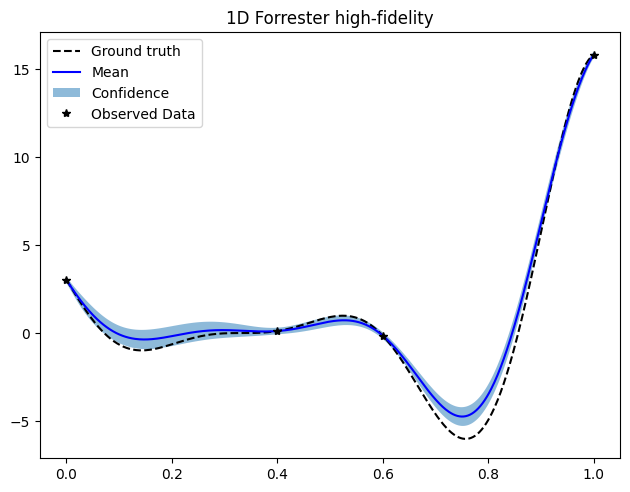

In [42]:
surrogate.plot_gpr(
        test_x=test_x, 
        scaler=scaler, 
        exact_y=exact_y_hf, 
        observed_pred=observed_pred_hf,
        train_x=train_x,
        train_y=torch.tensor(scaler.inverse_transform(train_y_scaled.numpy()[:, None]))
        )

plt.title('1D ' + fun.get_name() + ' high-fidelity')

# surrogate.plot_gpr(
#         test_x=test_x, 
#         scaler=scaler, 
#         exact_y=exact_y_lf, 
#         observed_pred=observed_pred_lf,
#         train_x=torch.tensor(mf_train_data[0].get_input_data().values),
#         train_y=torch.tensor(scaler.inverse_transform(mf_train_data[0].get_output_data().values))
#         )

# plt.title('1D ' + fun.get_name() + ' low-fidelity')

plt.show()

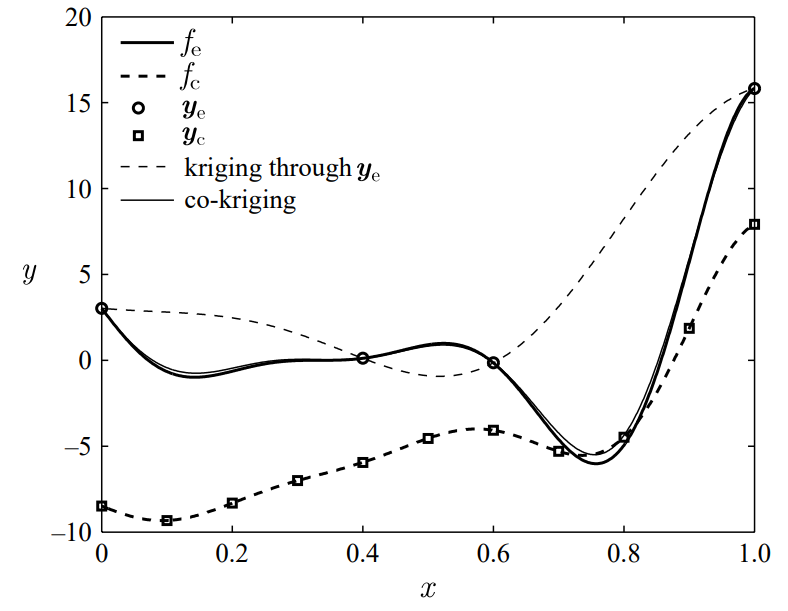

Plotting the likelihood landscape for multi-fidelity regression is currently under construction.

## 5. Error metrics

The error metrics are ostensibly the same as the ones applied to the single-fidelity case. In this scenario, both fidelities can be subjected to these metrics:

In [43]:
metrics_df = surrogate.gp_metrics(
    scaler=scaler,
    observed_pred=observed_pred_hf,
    exact_y=exact_y_hf.flatten(),
)

print(metrics_df)

                             1          2        inf
p-distance          230.473129  13.877886   1.457558
mean p-error          0.460946   0.385191   1.457558
sample p-deviation    2.717247  20.061029  15.358547
R^2_p                 0.830363   0.980799   0.905098


In [44]:
metrics_df_lf = surrogate.gp_metrics(
    scaler=scaler,
    observed_pred=observed_pred_lf,
    exact_y=exact_y_lf.flatten(),
)

print(metrics_df_lf)

                            1          2        inf
p-distance          13.938845   1.053674   0.183001
mean p-error         0.027878   0.002220   0.183001
sample p-deviation   2.842051  16.952585  12.679274
R^2_p                0.990191   0.999869   0.985567


## Exercises
1. Change the (base) function into the Schwefel function. What do you notice?
2. Use `50` high-fidelity data points and `500` low-fidelity data points. Compare the result with the single-fidelity result with suggested hyperparameter settings of Exercise 3 in part A. What do you notice?